# Monte Carlo Methods: Lab 2

In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

Point to note: an electronic copy of the [Frenkel and Smit book is available through the library](http://site.ebrary.com/lib/soton/detail.action?docID=10186686). This lab is based on case study 1 in chapter 3.4 of that book.

## Lennard-Jones fluids

When computing the interactions between lots of bodies (atoms, molecules, planets, etc) we can either use the *true* potential or force between them, or we can approximate it with some potential (or force) that is easier (and usually cheaper) to calculate. The parameters of the potential can then be set to approximate the "real" features we're interested in.

In computational chemistry, one such approximation is the *Lennard-Jones* potential. Given two bodies separated by a distance $r$, the potential generated by those two bodies is

\begin{equation}
  U(r) = 4 \varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right].
\end{equation}

Here $\varepsilon$ and $\sigma$ are parameters. When there are more than two bodies the total potential is the sum over all pairwise potentials.

In principle this generates a potential between particles that are separated by huge distances. Instead it is typical to *truncate* the potential: to pick a cut-off distance so that any particles separated by more than that distance do not contribute, and to correct for those small contributions.

Here we use a Lennard-Jones potential inside a box size $[0,L]^3$ with a cut-off $r_c = L/2$, with parameters set so that

\begin{equation}
U = \begin{cases} 4 \left[ \frac{1}{r^{12}} - \frac{1}{r^6} \right] & r < r_c \\ 0 & r > r_c. \end{cases}
\end{equation}

Include tail corrections (that is, additional energy and pressure terms resulting from the particles outside the cutoff radius) as

\begin{align}
  U^{\text{tail}} & = \frac{8 \pi \rho}{3} \left[ \frac{1}{3} \frac{1}{r_c^9} - \frac{1}{r_c^3} \right] \\
  p^{\text{tail}} & = \frac{16 \pi \rho^2}{3} \left[ \frac{2}{3} \frac{1}{r_c^9} - \frac{1}{r_c^3} \right].
\end{align}

For each configuration we need to compute the pressure using

$$
\begin{equation}
  p = \frac{\rho}{\beta} + \frac{\text{Virial}}{V}
\end{equation}
$$

where

$$
\begin{equation}
  \text{Virial} = \sum_i \sum_{j > i} \vec{f}( \vec{r}_{ij} ) \cdot \vec{r}_{ij}
\end{equation}
$$

where, as usual, $\vec{r}_{ij}$ is the separation between the atoms, $\vec{r}_{ij} = \vec{r}_i - \vec{r}_j$, and the intermolecular force $\vec{f}$ is given by

$$
\begin{align}
  \vec{f}(\vec{r}_{ij}) &= - \nabla U \\
  & = \begin{cases} 24 \left[ 2 \frac{1}{r^{14}} - \frac{1}{r^8} \right] \vec{r}_{ij} & r < r_c \\ \vec{0} & r > r_c \end{cases}
\end{align}
$$

Note that in the reduced coordinates $\beta = T^{-1}$.

## Monte Carlo code

We will be using an $NTV$ approach, keeping the number of particles fixed ($N = 100$), the temperature fixed ($T=2$) and the volume fixed (indirectly, via the density $\rho = N / V = N L^{-3}$; use $\rho = a/10$ for $a = 1, \dots, 9$, but start by just considering the $a=1, 2$ cases). You will need to take at least $10,000$ steps for the larger values of $a$; $20,000$ is better, but in all cases you should test with a smaller number of particles and steps ($1,000$ may be sufficient for small values of $a$).

For reference we note the solutions, taken from [Johnson, Zollweg and Gubbins](http://www.tandfonline.com/doi/abs/10.1080/00268979300100411) for the pressures at $T=2$ are:

In [2]:
p_JZG_T2 = [0.1776, 0.329, 0.489, 0.7, 1.071, 1.75, 3.028, 5.285, 9.12]

### Efficiency

Note that the sum over all particles scales as $n^2$ where $n$ is the number of particles. As the number of steps the algorithm will need to take will also scale as $n$, this makes the number of calculations at least as bad as $n^3$. This is expensive; if you try the naive approach then you'll have difficulty using more than 50 particles in a moderate time.

Instead we can note that, at each stage, the algorithm will move only one particle. Therefore, if we store not just the locations of the particles but also their pairwise separations, at each step we will only have to modify a small number of the separations. So we can store $r^2_{ij} = \vec{r}_{ij} \cdot \vec{r}_{ij}$ only, for $j > i$, and when perturbing particle $k$ we only need to update the separations $r^2_{ik}$ for $i<k$ and $r^2_{kj}$ for $k<j$.

This should significantly reduce the number of calculations done in each step.

In addition, note that for reasonable behaviour the acceptance rate should be $\sim 40\%$. This depends on the fractional perturbation distance $\Delta$; values $\sim 0.4$ are reasonable when $\rho \sim 0.1$, but values $\sim 0.02$ are reasonable when $\rho \sim 0.9$.

### Results

* Check that the energy has converged to a "constant" state.
* Plot a histogram of the energies to show that they follow the Boltzmann distribution.

In [3]:
%matplotlib inline
import numpy
from scipy import constants
from matplotlib import pyplot
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12,6)

In [4]:
from numba import jit

@jit
def potential_point(r2, BoxSize):
    
    Rc = BoxSize/2
    
    U = 0.0
    if r2 < Rc**2:
        U = 4.0*(r2**(-6)-r2**(-3))
    
    return U

In [5]:
@jit
def compute_distance(x, i, j, BoxSize):
    """
    Compute the distance (squared) between two particles
    """
    
    separation = x[i, :] - x[j, :]
    # Fix for periodic boundaries; if any component is > 0.5 BoxSize, there's a periodic point closer.
    for n in range(3):
        if (numpy.abs(separation[n]) > 0.5 * BoxSize):
            separation[n] -= BoxSize * numpy.sign(separation[n])
    return numpy.dot(separation, separation)

In [6]:
@jit
def pressure(x, BoxSize, rho, beta):
    """
    Compute the pressure for the configuration
    
    Parameters
    ----------
    
    x : array of float
        Location of the particles
    BoxSize : float
        Width of box (starts from zero)
    rho : float
        Density
    beta : float
        1 / (kB * T)
        
    Returns
    -------
    
    p : float
        pressure
    """
    
    N, ndim = x.shape
    
    Rc = BoxSize/2
    ptail = 16.0 * numpy.pi * rho**2 / 3.0 * (2.0 * Rc**(-9)/3.0 - Rc**(-3))
    p = ptail + rho / beta
    
    for i in range(N):
        for j in range(i+1, N):
            separation = x[i, :] - x[j, :]
            # Fix for periodic boundaries; if any component is > 0.5 BoxSize, there's a periodic point closer.
            for n in range(3):
                if (numpy.abs(separation[n]) > 0.5 * BoxSize):
                    separation[n] -= BoxSize * numpy.sign(separation[n])
            r2 = numpy.dot(separation, separation)
            if (r2 < Rc**2): # Only bother adding the term if the particles are close enough to interact
                p += 8.0 * (2.0 * r2**(-6) - r2**(-3))/BoxSize**3
    
    return p

In [7]:
def reset_particles(x, BoxSize):
    """
    Enforce the particles to lie within a box (periodic boundaries).
    
    Parameters
    ----------
    
    x : array of float
        Location of the particles
    BoxSize : float
        Width of box (starts from zero)
        
    Returns
    -------
    
    xnew : array of float
        Updated location of the particles
    """
    
    for n in range(3):
        for i in range(x.shape[0]):
            if (x[i,n] < 0.0):
                x[i,n] += BoxSize
            elif (x[i,n] > BoxSize):
                x[i,n] -= BoxSize
    return x

In [8]:
def perturb(x, r2, Upoints, BoxSize, Delta):
    """
    Perturb a configuration.
    
    Parameters
    ----------
    
    x : array of float
        Location of the particles
    r2 : array of float
        Pairwise separation distances (squared)
    BoxSize : float
        Width of box (starts from zero)
    Delta : float
        Fractional box width to perturb
        
    Returns
    -------
    
    xnew : array of float
        Updated location of the particles
    """
    
    from numpy.random import randint, rand
    
    N, ndim = x.shape
    
    Nparticle = randint(0,N)
    perturbation = Delta * BoxSize * (rand(3) - 0.5)
    
    xnew = x.copy()
    r2new = r2.copy()
    Upoints_new = Upoints.copy()
    xnew[Nparticle, :] += perturbation
    xnew = reset_particles(xnew, BoxSize)
    for i in range(Nparticle):
        r2new[i, Nparticle] = compute_distance(xnew, i, Nparticle, BoxSize)
        Upoints_new[i, Nparticle] = potential_point(r2new[i, Nparticle], BoxSize)
    for i in range(Nparticle+1, N):
        r2new[Nparticle, i] = compute_distance(xnew, Nparticle, i, BoxSize)
        Upoints_new[Nparticle, i] = potential_point(r2new[Nparticle, i], BoxSize)
    
    dU = numpy.sum(Upoints_new[:Nparticle,Nparticle])+\
        numpy.sum(Upoints_new[Nparticle,Nparticle:])-\
        numpy.sum(Upoints[:Nparticle,Nparticle])-\
        numpy.sum(Upoints[Nparticle,Nparticle:])
    
    return xnew, r2new, Upoints_new, dU

In [9]:
def mc_step(x, r2, Upoints, BoxSize, rho, beta, U, accepted, Delta):
    """
    Take a single Monte Carlo step
    
    Parameters
    ----------
    
    x : array of float
        Location of the particles
    r2 : array of float
        Pairwise separation distances (squared)
    BoxSize : float
        Width of box (starts from zero)
    rho : float
        Density
    beta : float
        1 / (kB * T)
    U : float
        Energy
        
    Returns
    -------
    
    x_new : array of float
        Updated location of the particles
    U_new : float
        Updated energy
    """
    
    x_new, r2_new, Upoints_new, dU = perturb(x, r2, Upoints, BoxSize, Delta)
    U_new = U + dU
    
    p = rand()
    if dU < 0 or p < numpy.min([1.0, numpy.exp(-beta*dU)]):
        accepted +=1
        x_ret = x_new
        r2_ret = r2_new
        Upoints_ret = Upoints_new
        U_ret = U_new
    else:
        x_ret = x
        r2_ret = r2
        Upoints_ret = Upoints
        U_ret = U
    
    return x_ret, r2_ret, Upoints_ret, U_ret, accepted

In [10]:
from numpy.random import rand

In [11]:
Nparticles = 50
Temperature = [2.0]
Density = numpy.arange(0.1, 1.0, 0.1)
Deltas = [0.4, 0.3, 0.2, 0.15, 0.15, 0.12, 0.1, 0.08, 0.05]
Nsteps = 5000

In [18]:
Energy = numpy.zeros((len(Temperature), len(Density), Nsteps+1))
Pressure = numpy.zeros((len(Temperature), len(Density)))
for nt, T in enumerate(Temperature):
    beta = 1.0 / (T) # In reduced units
    for nd, rho in enumerate(Density):
        BoxSize = (Nparticles / rho)**(1.0/3.0)
        print("Step {}".format(nd))
        # Re-use the previous configuration if available, as it's likely close to equilibrium
        if nd == 0:
            configuration_initial = BoxSize*rand(Nparticles, 3)
        else:
            configuration_initial = (Density[nd-1]/Density[nd])**(1.0/3.0)*configuration_new
        # Reset the box so the centre of mass is in the middle of the box
        com = numpy.sum(configuration_initial, axis=0)/Nparticles
        configuration_initial -= com
        configuration_initial += BoxSize/2.0*numpy.ones((3,))
        configuration_initial = reset_particles(configuration_initial, BoxSize)
        r2_initial = numpy.zeros((Nparticles, Nparticles))
        Upoints_initial = numpy.zeros((Nparticles, Nparticles))
        for i in range(Nparticles):
            for j in range(i+1, Nparticles):
                r2_initial[i,j] = compute_distance(configuration_initial, i, j, BoxSize)
                Upoints_initial[i,j] = potential_point(r2_initial[i,j], BoxSize)
        configuration_old = configuration_initial.copy()
        r2_old = r2_initial.copy()
        Upoints_old = Upoints_initial.copy()
        #U_old = potential(configuration_old, r2_old, BoxSize, rho)
        U_old = numpy.sum(Upoints_old)
        Energy[nt, nd, 0] = U_old
        accepted = 0
        for n in range(1, Nsteps+1):
            configuration_new, r2_new, Upoints_new, U_new, accepted = mc_step(configuration_old, r2_old, Upoints_old, BoxSize, rho, beta, U_old, accepted, Deltas[nd])
            configuration_old = configuration_new.copy()
            r2_old = r2_new.copy()
            U_old = U_new
            Upoints_old = Upoints_new.copy()
            Energy[nt, nd, n] = U_new
        Pressure[nt, nd] = pressure(configuration_new, BoxSize, rho, beta)
        print(accepted,accepted/float(Nsteps))

Step 0
(2749, 0.5498)
Step 1
(2208, 0.4416)
Step 2
(2239, 0.4478)
Step 3
(2173, 0.4346)
Step 4
(1750, 0.35)
Step 5
(1916, 0.3832)
Step 6
(1716, 0.3432)
Step 7
(1879, 0.3758)
Step 8
(2516, 0.5032)


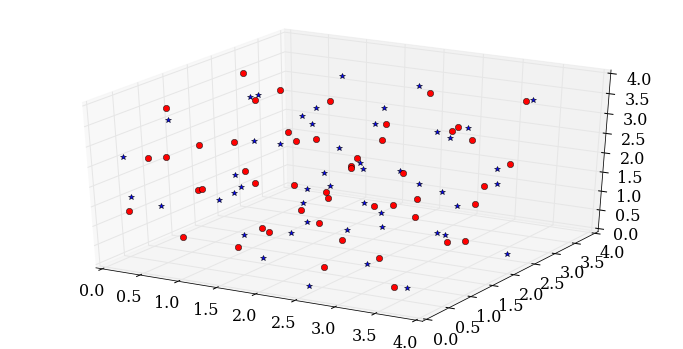

In [19]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(configuration_initial[:,0], configuration_initial[:,1], configuration_initial[:,2], 'b*')
ax.plot3D(configuration_new[:,0], configuration_new[:,1], configuration_new[:,2], 'ro')

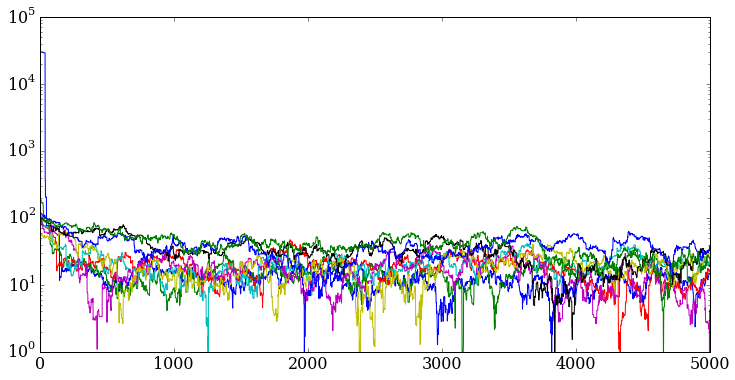

In [20]:
fig = pyplot.figure()
ax1 = fig.add_subplot(111)
for i in range(Energy.shape[1]):
    ax1.semilogy(Energy[0,i,:]-numpy.min(Energy[0,i,:])+1)

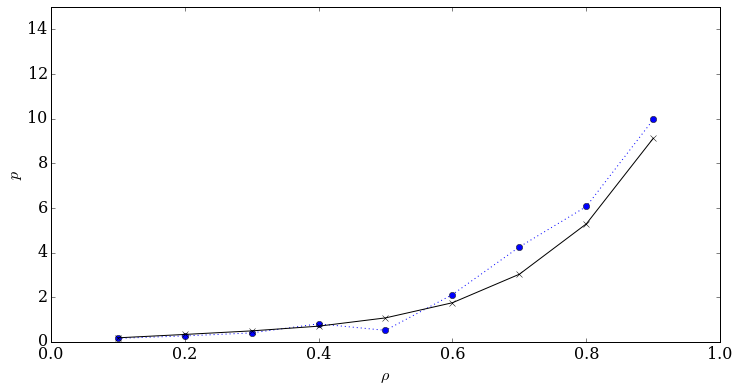

In [21]:
fig = pyplot.figure()
ax1 = fig.add_subplot(111)
ax1.plot(Density, Pressure[0, :], 'bo:', label = "MC code")
ax1.plot(Density, p_JZG_T2, 'kx-', label = "Reference solution")
ax1.set_xlabel(r"$\rho$")
ax1.set_ylabel(r"$p$")
ax1.set_xlim(0.0,1.0)
ax1.set_ylim(0.0,15.0);

The energies should follow a Boltzmann distribution, $e^{-\beta U}$ in state space. However, the symmetries of the system mean that the number of *computationally* independent states with the same energy goes as $U^3$. So plotting a histogram of the energies (normalized so that the ground state has $U=0$) should give something like $U^3 e^{-\beta U}$.

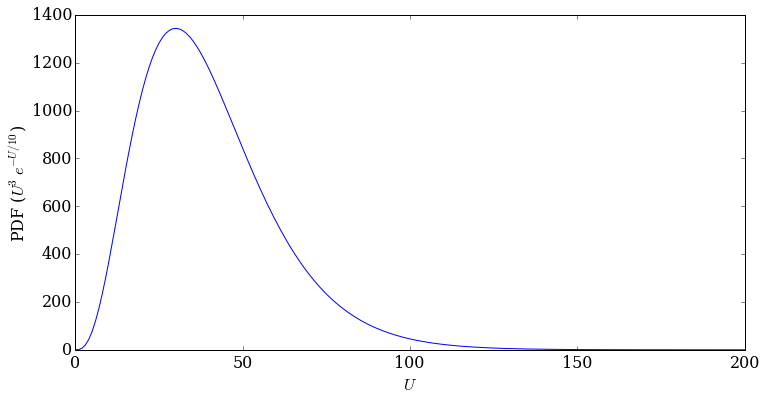

In [22]:
U = numpy.linspace(0, 200, 200)
pyplot.plot(U, U**3*numpy.exp(-U/10.0))
pyplot.xlabel(r"$U$")
pyplot.ylabel(r"PDF ($U^3 e^{-U/10}$)")
pyplot.show();

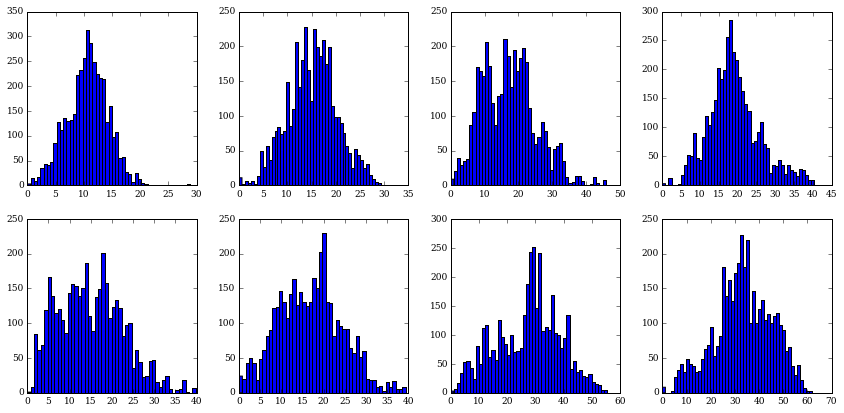

In [23]:
# Histograms for each case when T=2. Remove the first 1000. Suggest we should be running for more steps...
fig = pyplot.figure()
for i in range(2):
    for j in range(4):
        k = j+4*i
        ecut = Energy[0,k,1000:]-numpy.min(Energy[0,k,1000:])
        ax = fig.add_subplot(2,4,k+1)
        ax.hist(ecut, bins=50);
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(9)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(9)
fig.tight_layout()